# Summary
This notebook reproduces the plots corresponding to the results of the synthetic experiments.

In [1]:
import sys
sys.path.insert(0, r"..\code")

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ptitprince as pt
import seaborn as sns

from MCB import delta_score, vdelta_score, vloglike
from copy import deepcopy
from utils import save_obj, load_obj
from metrics import is_dag, get_DAG, get_CPDAG
from tqdm.notebook import trange
from sklearn.metrics import f1_score, recall_score, precision_score

In [2]:
data_dir="../data/"
ts_dir="../data/TimeSeriesAAL/" 
processed="../data/processed/"
diffreg="../data/processed/diff_regions/"
fig_dir="../figs/"

In [3]:
replace=False
verbose=False

In [4]:
def hamming(B_est, B_true):
    
    # linear index of nonzeros
    pred_und = np.flatnonzero(B_est == -1)
    pred = np.flatnonzero(B_est == 1)
    cond = np.flatnonzero(B_true)
    cond_reversed = np.flatnonzero(B_true.T)

    # reverse
    extra = np.setdiff1d(pred, cond, assume_unique=True)
    reverse = np.intersect1d(extra, cond_reversed, assume_unique=True)

    # structural hamming distance
    pred_lower = np.flatnonzero(np.tril(B_est + B_est.T))
    cond_lower = np.flatnonzero(np.tril(B_true + B_true.T))
    extra_lower = np.setdiff1d(pred_lower, cond_lower, assume_unique=True)
    missing_lower = np.setdiff1d(cond_lower, pred_lower, assume_unique=True)
    shd = len(extra_lower) + len(missing_lower) + len(reverse)

    return shd

In [5]:
data=load_obj("2.1_data", processed)
print(data['info'])

S,K,T=data[0]['X_skt'].shape
lmbds=[1.e-3, 5.e-3, 1.e-2, 5.e-2, 1.e-1, 5.e-1]
nsims=50

results=load_obj("2.2_synth_results", processed)

S: # of subjects;
K: # of ts;
T: length of ts;
X_skt: data generated from the causal structure;
C_skk: causal structure;
B_kk: backbone.


In [6]:
Corr_skk=np.zeros((nsims,S,K,K))
MI_skk=np.zeros((nsims,S,K,K))
PC_skk=np.zeros((nsims,S,K,K))
dtf_skk=np.zeros((nsims,S,K,K))
pdc_skk=np.zeros((nsims,S,K,K))
C_l_skk= dict()

for idx_l, lmbd in enumerate(lmbds):
    C_l_skk[lmbd]=np.zeros_like(Corr_skk)
    for sim in range(nsims):
        for s in range(S):
            if idx_l==0:
                Corr_skk[sim,s] = results[sim][s]['Corr']
                MI_skk[sim,s] = results[sim][s]['MI']
                PC_skk[sim,s] = results[sim][s]['PC']
                dtf_skk[sim,s]=results[sim][s]['DTF']
                pdc_skk[sim,s]=results[sim][s]['PDC']
            C_l_skk[lmbd][sim,s]=results[sim][s][lmbd]['C_hat']

# Hard-thresholding and comparison functional connectivity vs backbone

In [7]:
def retrieve_backbone(X_skt, C_skk, thresh, persistence, parallelized=True, method='pinv'):
        
    X=jnp.array(X_skt)
    C_spk=jnp.array(C_skk)

    S,K,T=X.shape
    
    A = jnp.zeros((K,K), dtype=jnp.int16) #solution

    #cut at certain threshold
    A_spk = jnp.sign((jnp.abs(C_spk)>thresh).astype(jnp.int16)).astype(jnp.int16) 
    G = jnp.where(jnp.sum(jnp.sign(jnp.abs(C_spk)), axis=0)>persistence, -1, 0)

    P_spk = (A_spk+G).astype(jnp.int16) #idiosyncratic connections
    P_spk = jnp.where(P_spk==-1., 0., P_spk)

    print("Universe initially has {} edges\n".format(len(jnp.flatnonzero(G))))

    if len(jnp.flatnonzero(G))==0: 
        return np.array(A), np.zeros((S,K,K)) 

    LLG = -jnp.inf*jnp.ones((S,K,K)) #log-likelihood given the insertion of candidate edges: needed for selecting the likelihood associated with best edge
    LLA = [vloglike(X[:,i], X, C_spk[...,i]*P_spk[...,i]) for i in range(K)] #log-likelihood given edges in A

    #needed to store changes in causal coefficients given an edge addition.
    #So, for each subject, the entry of the matrix KxK is the vector of coefficients
    #resulting from the addition of the edge corresponding to that entry.
    B_augmented = jnp.zeros((S,K,K,K)) 
    B = jnp.zeros((S,K,K)) #this is the final causal coefficients tensor.
    
    evaluate_candidate = True
    first_step=True
    isdag=True #dagness condition

    while evaluate_candidate:
        
        evaluate_candidate=False
        
        #only update the scores if the edge has been added
        if isdag:
            if first_step:
                children=jnp.unique(G.nonzero()[1]) #nodes on the columns with at least 1 parent
                first_step=False
            else: 
                children=[child_of_last_edge_added_idx]

            for child in children:
                
                child_columns=P_spk[...,child]+A[:,child]
                candidate_parents = G[:,child].nonzero()[0].tolist()
                ll0 = LLA[child]

                for candidate_parent in candidate_parents:
                    
                    if not parallelized:
                        scores_candidate = jnp.zeros(S)
                        lls_candidate = jnp.zeros(S)
                        betas_child = jnp.zeros([S,K])
                        
                        for subject in range(S):
                            score_candidate_item, ll_candidate_item, betas_child_item=delta_score(candidate_parent, child, child_columns[subject], X[subject], ll0[subject], method, parallelized)
                            
                            scores_candidate=scores_candidate.at[subject].set(score_candidate_item)
                            lls_candidate=lls_candidate.at[subject].set(ll_candidate_item)
                            betas_child=betas_child.at[subject].set(betas_child_item)
                    
                    elif parallelized:  
                        #this is vmapped (parallelized).
                        scores_candidate, lls_candidate, betas_child=vdelta_score(candidate_parent, child, child_columns, X, ll0, method, parallelized)
                    
                    score_candidate = scores_candidate.sum()

                    B_augmented = B_augmented.at[:,:,candidate_parent,child].set(betas_child)
                    G = G.at[candidate_parent,child].set(score_candidate)
                    LLG = LLG.at[:,candidate_parent,child].set(lls_candidate)
        
        max_score = G.max().item()
        idx_max = jnp.unravel_index(G.argmax(), G.shape)
        if max_score>0:
            parent_of_last_edge_added, child_of_last_edge_added=idx_max
            parent_of_last_edge_added_idx, child_of_last_edge_added_idx=parent_of_last_edge_added.item(), child_of_last_edge_added.item()
            
            #check aciclycity
            A_tilde = deepcopy(A).astype(jnp.float32)
            A_tilde = A_tilde.at[parent_of_last_edge_added_idx, child_of_last_edge_added_idx].set(1.)
            
            isdag = is_dag(np.asarray(A_tilde))

            if isdag:
                A = A.at[parent_of_last_edge_added_idx, child_of_last_edge_added_idx].set(1)
                B = B.at[:,:, child_of_last_edge_added_idx].set(B_augmented[:,:,parent_of_last_edge_added_idx,child_of_last_edge_added_idx])
                LLA[child_of_last_edge_added_idx]=LLG[:,parent_of_last_edge_added_idx, child_of_last_edge_added_idx]
                common_edges=(jnp.cumsum(jnp.sign(jnp.abs(B)), axis=0)[-1]==S).sum()
                if verbose:
                    print("Added {}->{}".format(parent_of_last_edge_added_idx,child_of_last_edge_added_idx))
                    print("Number of common edges {}".format(common_edges))
            else:
                if verbose: print("Not added {}->{} since it induces cicles in the solution.".format(parent_of_last_edge_added_idx,child_of_last_edge_added_idx))
        
        #remove the evaluated edge
        G = G.at[(parent_of_last_edge_added_idx,child_of_last_edge_added_idx)].set(0.)
        #if added exclude its reverse
        if isdag:
            G = G.at[(child_of_last_edge_added_idx,parent_of_last_edge_added_idx)].set(0.)
        G = jnp.where(G<0., 0., G)
        # display(jnp.sign(G))

        # if added: evaluate_candidate=True    
        if len(jnp.where(G>0.)[0])>0: 
            evaluate_candidate=True 

    print("\n Added {} edges".format(len(jnp.flatnonzero(A))))
    
    return np.array(A), np.array(B)

In [8]:
ps = [60, 65, 70, 75, 80, 85, 90, 95]
threshs = [0., 0.05, .1, 0.15, .2, 0.25, .3]

ncombos = nsims*len(ps)*len(threshs)*(5+len(lmbds))
metrics_df=pd.DataFrame(index=np.arange(ncombos), columns=['sim', 'method', 'persistence', 'threshold', 'lmbd', 'precision', 'recall', 'f1', 'Hamming', 'true_nnz'])
print(ncombos)
display(metrics_df)

30800


,sim,method,persistence,threshold,lmbd,precision,recall,f1,Hamming,true_nnz
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
30795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
if replace:
    counter=0

    for sim in trange(nsims):
        B_kk = data[sim]['B_kk']
        X_skt = data[sim]['X_skt']
        
        for p in ps:   
            for t in threshs:
                A_Corr_skk = np.triu(np.where(np.abs(Corr_skk[sim])>t, 1, 0), k=1)
                A_MI_skk = np.triu(np.where(np.abs(MI_skk[sim])>t, 1, 0), k=1)
                A_PC_skk = np.triu(np.where(np.abs(PC_skk[sim])>t, 1, 0), k=1)
                A_DTF_skk = np.where(np.abs(dtf_skk[sim])>t, 1, 0)
                A_PDC_skk = np.where(np.abs(pdc_skk[sim])>t, 1, 0)

                B_corr = np.where(np.sum(A_Corr_skk, axis=0)>=p, 1, 0)
                B_MI = np.where(np.sum(A_MI_skk, axis=0)>=p, 1, 0)
                B_PC = np.where(np.sum(A_PC_skk, axis=0)>=p, 1, 0) 
                B_DTF = np.where(np.sum(A_DTF_skk, axis=0)>=p, 1, 0) 
                B_PDC = np.where(np.sum(A_PDC_skk, axis=0)>=p, 1, 0)

                metrics_df.loc[counter] = [sim, 'Correlation', p, t, 'n/a',
                                            precision_score(B_kk.flatten(), B_corr.flatten()),
                                            recall_score(B_kk.flatten(), B_corr.flatten()),
                                            f1_score(B_kk.flatten(), B_corr.flatten()),
                                            len(np.flatnonzero(B_kk-B_corr)),
                                            len(np.flatnonzero(B_kk))]
                
                counter+=1

                metrics_df.loc[counter] = [sim,'Mutual information', p, t, 'n/a',
                                            precision_score(B_kk.flatten(), B_MI.flatten()),
                                            recall_score(B_kk.flatten(), B_MI.flatten()),
                                            f1_score(B_kk.flatten(), B_MI.flatten()),
                                            len(np.flatnonzero(B_kk-B_MI)),
                                            len(np.flatnonzero(B_kk))]
                
                counter+=1

                metrics_df.loc[counter] = [sim,'Partial correlation', p, t, 'n/a',
                                            precision_score(B_kk.flatten(), B_PC.flatten()),
                                            recall_score(B_kk.flatten(), B_PC.flatten()),
                                            f1_score(B_kk.flatten(), B_PC.flatten()),
                                            len(np.flatnonzero(B_kk-B_PC)),
                                            len(np.flatnonzero(B_kk))]
                
                counter+=1

                for lmbd in lmbds:
                    B_causal, _ = retrieve_backbone(X_skt=X_skt, C_skk=C_l_skk[lmbd][sim], thresh=t, persistence=p)
                    metrics_df.loc[counter] = [sim,'Causal', p, t, lmbd,
                                            precision_score(B_kk.flatten(), B_causal.flatten()),
                                            recall_score(B_kk.flatten(), B_causal.flatten()),
                                            f1_score(B_kk.flatten(), B_causal.flatten()),
                                            hamming(get_CPDAG(B_kk), get_CPDAG(B_causal)),
                                            len(np.flatnonzero(B_kk))]
                    
                    counter+=1

                metrics_df.loc[counter] = [sim,'DTF', p, t, 'n/a',
                                            precision_score(B_kk.flatten(), B_DTF.flatten()),
                                            recall_score(B_kk.flatten(), B_DTF.flatten()),
                                            f1_score(B_kk.flatten(), B_DTF.flatten()),
                                            hamming(get_CPDAG(B_kk), get_CPDAG(np.triu(B_DTF,1)+np.tril(B_DTF,-1))),
                                            len(np.flatnonzero(B_kk))]
                
                counter+=1

                metrics_df.loc[counter] = [sim,'PDC', p, t, 'n/a',
                                            precision_score(B_kk.flatten(), B_PDC.flatten()),
                                            recall_score(B_kk.flatten(), B_PDC.flatten()),
                                            f1_score(B_kk.flatten(), B_PDC.flatten()),
                                            hamming(get_CPDAG(B_kk), get_CPDAG(np.triu(B_PDC,1)+np.tril(B_PDC,-1))),
                                            len(np.flatnonzero(B_kk))]
                
                counter+=1
    
    save_obj(metrics_df, "2.3_metrics_df", processed)

else:
    metrics_df=load_obj("2.3_metrics_df", processed)

# Plots

In [10]:
LEGEND_SIZE = 11
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE, weight='bold')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

plt.rcParams['text.usetex'] = True

In [11]:
metrics_df[metrics_df['method']=='Causal'].groupby(['method','persistence', 'threshold', 'lmbd']).median().sort_values(by='f1', ascending=False).head(10)

sim  precision  recall   f1  Hamming  \
method persistence threshold lmbd                                           
Causal 60          0.30      0.010  24.5        1.0     1.0  1.0      0.0   
                   0.15      0.010  24.5        1.0     1.0  1.0      0.0   
       65          0.15      0.010  24.5        1.0     1.0  1.0      0.0   
                             0.005  24.5        1.0     1.0  1.0      0.0   
                             0.001  24.5        1.0     1.0  1.0      0.0   
       60          0.20      0.010  24.5        1.0     1.0  1.0      0.0   
                             0.050  24.5        1.0     1.0  1.0      0.0   
       65          0.10      0.010  24.5        1.0     1.0  1.0      0.0   
                             0.005  24.5        1.0     1.0  1.0      0.0   
                             0.001  24.5        1.0     1.0  1.0      0.0   

                                    true_nnz  
method persistence threshold lmbd             
Causal 60          0.30      0.010      12.0  
                   0.15      0.010      12.0  
       65          0.15      0.010      12.0  
                             0.005      12.0  
                             0.001      12.0  
       60          0.20      0.010      12.0  
                             0.050      12.0  
       65          0.10      0.010      12.0  
                             0.005      12.0  
                             0.001      12.0

In [12]:
metrics_df[metrics_df['method']=='Mutual information'].groupby(['method','persistence', 'threshold', 'lmbd']).median().sort_values(by='f1', ascending=False).head(10)

sim  precision    recall  \
method             persistence threshold lmbd                              
Mutual information 60          0.05      n/a   24.5   0.875000  0.666667   
                   85          0.00      n/a   24.5   0.431677  0.916667   
                   90          0.00      n/a   24.5   0.720779  0.500000   
                   65          0.05      n/a   24.5   1.000000  0.333333   
                   80          0.00      n/a   24.5   0.300000  1.000000   
                   75          0.00      n/a   24.5   0.272727  1.000000   
                   70          0.00      n/a   24.5   0.266667  1.000000   
                   60          0.00      n/a   24.5   0.266667  1.000000   
                   65          0.00      n/a   24.5   0.266667  1.000000   
                   70          0.05      n/a   24.5   1.000000  0.083333   

                                                     f1  Hamming  true_nnz  
method             persistence threshold lmbd                               
Mutual information 60          0.05      n/a   0.755952      5.0      12.0  
                   85          0.00      n/a   0.586801     15.5      12.0  
                   90          0.00      n/a   0.571429      8.5      12.0  
                   65          0.05      n/a   0.500000      8.0      12.0  
                   80          0.00      n/a   0.461538     28.0      12.0  
                   75          0.00      n/a   0.428571     32.0      12.0  
                   70          0.00      n/a   0.421053     33.0      12.0  
                   60          0.00      n/a   0.421053     33.0      12.0  
                   65          0.00      n/a   0.421053     33.0      12.0  
                   70          0.05      n/a   0.153846     11.0      12.0

In [13]:
metrics_df[metrics_df['method']=='Partial correlation'].groupby(['method', 'persistence', 'threshold', 'lmbd']).median().sort_values(by='f1', ascending=False).head(10)

sim  precision    recall  \
method              persistence threshold lmbd                              
Partial correlation 65          0.15      n/a   24.5   0.846154  0.916667   
                    75          0.10      n/a   24.5   0.800000  0.916667   
                    70          0.15      n/a   24.5   1.000000  0.750000   
                    60          0.20      n/a   24.5   1.000000  0.708333   
                    80          0.10      n/a   24.5   1.000000  0.666667   
                    90          0.05      n/a   24.5   0.900000  0.750000   
                    85          0.05      n/a   24.5   0.666667  1.000000   
                    60          0.15      n/a   24.5   0.647059  1.000000   
                    65          0.20      n/a   24.5   1.000000  0.583333   
                    70          0.10      n/a   24.5   0.589474  1.000000   

                                                      f1  Hamming  true_nnz  
method              persistence threshold lmbd                               
Partial correlation 65          0.15      n/a   0.880000      3.0      12.0  
                    75          0.10      n/a   0.851648      4.0      12.0  
                    70          0.15      n/a   0.818182      4.0      12.0  
                    60          0.20      n/a   0.800000      4.0      12.0  
                    80          0.10      n/a   0.800000      4.0      12.0  
                    90          0.05      n/a   0.800000      4.0      12.0  
                    85          0.05      n/a   0.779954      6.0      12.0  
                    60          0.15      n/a   0.774194      7.0      12.0  
                    65          0.20      n/a   0.736842      5.0      12.0  
                    70          0.10      n/a   0.730303      8.5      12.0

In [14]:
metrics_df[metrics_df['method']=='Correlation'].groupby(['method', 'persistence', 'threshold', 'lmbd']).median().sort_values(by='f1', ascending=False).head(10)

sim  precision    recall        f1  \
method      persistence threshold lmbd                                        
Correlation 65          0.25      n/a   24.5   0.851648  0.750000  0.807407   
            70          0.20      n/a   24.5   0.689904  0.916667  0.778401   
            60          0.30      n/a   24.5   0.900000  0.666667  0.765568   
                        0.25      n/a   24.5   0.594118  1.000000  0.720779   
            85          0.10      n/a   24.5   0.644958  0.833333  0.717143   
            75          0.20      n/a   24.5   0.888889  0.583333  0.710000   
            80          0.15      n/a   24.5   0.833333  0.666667  0.697826   
            75          0.15      n/a   24.5   0.545455  1.000000  0.685714   
            65          0.20      n/a   24.5   0.461538  1.000000  0.631579   
            90          0.05      n/a   24.5   0.434783  0.916667  0.594595   

                                        Hamming  true_nnz  
method      persistence threshold lmbd                     
Correlation 65          0.25      n/a       5.0      12.0  
            70          0.20      n/a       6.0      12.0  
            60          0.30      n/a       5.0      12.0  
                        0.25      n/a       8.5      12.0  
            85          0.10      n/a       7.5      12.0  
            75          0.20      n/a       6.0      12.0  
            80          0.15      n/a       7.0      12.0  
            75          0.15      n/a      10.0      12.0  
            65          0.20      n/a      14.0      12.0  
            90          0.05      n/a      15.0      12.0

In [15]:
metrics_df[metrics_df['method']=='DTF'].groupby(['method', 'persistence', 'threshold', 'lmbd']).median().sort_values(by='f1', ascending=False).head(10)

sim  precision  recall        f1  Hamming  \
method persistence threshold lmbd                                               
DTF    60          0.00      n/a   24.5       0.12     1.0  0.214286     45.0   
       65          0.00      n/a   24.5       0.12     1.0  0.214286     45.0   
       95          0.00      n/a   24.5       0.12     1.0  0.214286     45.0   
       90          0.00      n/a   24.5       0.12     1.0  0.214286     45.0   
       85          0.00      n/a   24.5       0.12     1.0  0.214286     45.0   
       75          0.00      n/a   24.5       0.12     1.0  0.214286     45.0   
       70          0.00      n/a   24.5       0.12     1.0  0.214286     45.0   
       80          0.00      n/a   24.5       0.12     1.0  0.214286     45.0   
       65          0.05      n/a   24.5       0.00     0.0  0.000000     12.0   
                   0.10      n/a   24.5       0.00     0.0  0.000000     12.0   

                                   true_nnz  
method persistence threshold lmbd            
DTF    60          0.00      n/a       12.0  
       65          0.00      n/a       12.0  
       95          0.00      n/a       12.0  
       90          0.00      n/a       12.0  
       85          0.00      n/a       12.0  
       75          0.00      n/a       12.0  
       70          0.00      n/a       12.0  
       80          0.00      n/a       12.0  
       65          0.05      n/a       12.0  
                   0.10      n/a       12.0

In [16]:
metrics_df[metrics_df['method']=='PDC'].groupby(['method', 'persistence', 'threshold', 'lmbd']).median().sort_values(by='f1', ascending=False).head(10)

sim  precision    recall        f1  \
method persistence threshold lmbd                                        
PDC    60          0.00      n/a   24.5   0.120000  1.000000  0.214286   
       65          0.00      n/a   24.5   0.120000  1.000000  0.214286   
       95          0.00      n/a   24.5   0.120000  1.000000  0.214286   
       90          0.00      n/a   24.5   0.120000  1.000000  0.214286   
       85          0.00      n/a   24.5   0.120000  1.000000  0.214286   
       75          0.00      n/a   24.5   0.120000  1.000000  0.214286   
       70          0.00      n/a   24.5   0.120000  1.000000  0.214286   
       80          0.00      n/a   24.5   0.120000  1.000000  0.214286   
       60          0.05      n/a   24.5   0.142857  0.166667  0.153846   
       65          0.05      n/a   24.5   0.076923  0.083333  0.080000   

                                   Hamming  true_nnz  
method persistence threshold lmbd                     
PDC    60          0.00      n/a      45.0      12.0  
       65          0.00      n/a      45.0      12.0  
       95          0.00      n/a      45.0      12.0  
       90          0.00      n/a      45.0      12.0  
       85          0.00      n/a      45.0      12.0  
       75          0.00      n/a      45.0      12.0  
       70          0.00      n/a      45.0      12.0  
       80          0.00      n/a      45.0      12.0  
       60          0.05      n/a      12.0      12.0  
       65          0.05      n/a      12.0      12.0

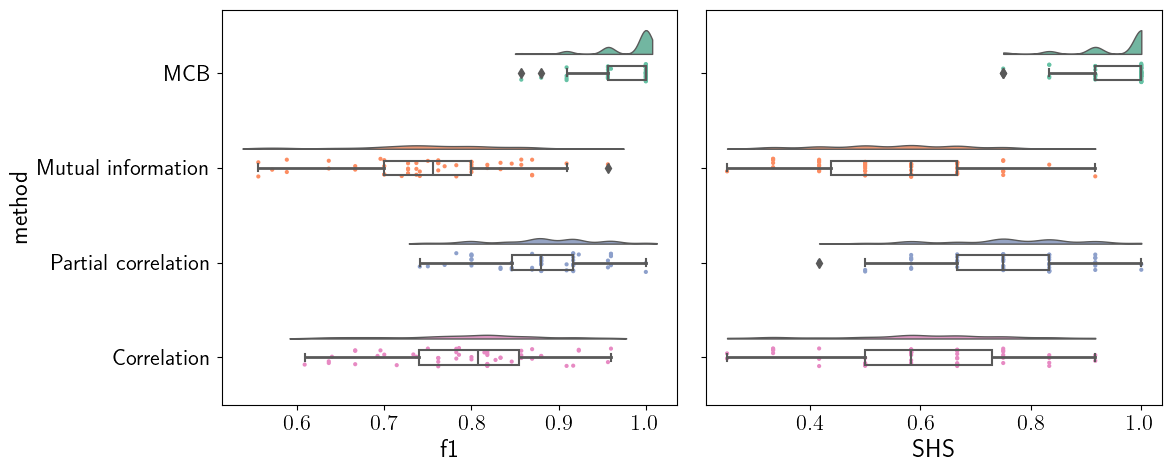

In [17]:
complete=False

#plots
to_plt = metrics_df[(metrics_df['method']=='Causal') & (metrics_df['persistence']==65) & (metrics_df['threshold']==0.15) & (metrics_df['lmbd']==0.010)].copy()
to_plt1 = metrics_df[(metrics_df['method']=='Mutual information') & (metrics_df['persistence']==60) & (metrics_df['threshold']==0.05)].copy()
to_plt2 = metrics_df[(metrics_df['method']=='Partial correlation') & (metrics_df['persistence']==65) & (metrics_df['threshold']==0.15)].copy()
to_plt3 =metrics_df[(metrics_df['method']=='Correlation') & (metrics_df['persistence']==65) & (metrics_df['threshold']==0.25)].copy()
to_plt4 =metrics_df[(metrics_df['method']=='DTF') & (metrics_df['persistence']==60) & (metrics_df['threshold']==0.00)].copy()
to_plt5 =metrics_df[(metrics_df['method']=='PDC') & (metrics_df['persistence']==60) & (metrics_df['threshold']==0.00)].copy()

if complete:
    to_plt = pd.concat([to_plt, to_plt1, to_plt2, to_plt3, to_plt4, to_plt5])
else:
    to_plt = pd.concat([to_plt, to_plt1, to_plt2, to_plt3])

to_plt.reset_index(drop=True, inplace=True)
to_plt['SHS'] = 1-to_plt['Hamming']/to_plt['true_nnz']

to_plt=to_plt.astype({'method':'str', 
               'persistence':'int32', 
               'threshold':'float64', 
               'lmbd':'str', 
               'precision':'float64', 
               'recall':'float64', 
               'f1':'float64', 
               'Hamming':'int32', 
               'true_nnz':'int32',
               'SHS':'float32'})

to_plt['method'] = to_plt['method'].apply(lambda x: 'MCB' if x=='Causal' else x)

fig , ax = plt.subplots(1,2,figsize=(12,5), sharey=True)
pt.RainCloud(data=to_plt, x='method', y='f1', palette = "Set2", bw = .2, width_viol = .5, orient = 'h', dodge=False, cut=True, ax=ax[0])
pt.RainCloud(data=to_plt, x='method', y='SHS', palette = "Set2", bw = .2, width_viol = .5, orient = 'h', ax=ax[1])
ax[1].set_ylabel("")
plt.tight_layout()

if replace:
    if complete:
        plt.savefig(fig_dir+"2.3_rainplot_full.pdf", dpi=1200)
        pass
    else:
        plt.savefig(fig_dir+"2.3_rainplot_readable.pdf", dpi=1200)
        pass
plt.show()